# 3

### 3.b.2 


_Berrendero, J. R., Justel, A., & Svarc, M. (2011)_

Sean los p procesos, cada uno en el **mismo intervalo T**:

$$\chi_1, \dots, \chi_p$$

Note que al tomar el punto $t\in T$, se tiene un vector:

$$\chi_1(t) = [X_{11}(t), \dots, X_{1n}(t)]^T$$ 

Por ellos se define la matriz 

$$\begin{bmatrix}\chi_1(t) | \chi_2(t) | \dots | \chi_p(t)\end{bmatrix}$$ 

Y se toman la matriz de covarianza de la matriz anterior, la cual se denota como:

$$\Sigma(t) = \begin{bmatrix} \Sigma_{11}(t) & \Sigma_{12}(t) & \dots & \Sigma_{1p}(t) \\ \Sigma_{21}(t) & \Sigma_{22}(t) & \dots & \Sigma_{2p}(t) \\ \vdots & \vdots & \ddots & \vdots \\ \Sigma_{p1}(t) & \Sigma_{p2}(t) & \dots & \Sigma_{pp}(t) \end{bmatrix}$$

Pero tomando todos los puntos, se tiene la sucesión de matrices de covarianza:

$$\Sigma_1, \Sigma_2, \dots, \Sigma_T$$

Tomando los valores propios y vectores propios de cada matriz de covarianza, se tiene que para cada $t\in T$:

$$\Sigma_t = \lambda(t) V_t $$

Donde $\lambda(t)$ es una **función** y loz vectores $V_t$ son dependientes de $t$. La idea es unir los vectores en un vector de funciones.


Cual multiplo de los vectores propios es vector propio, es decir, si $V_t$ es vector propio, entonces $cV_t$ también lo es, mostrando que al ser multiplicado **por un c negativo cambia de dirección**, haciendo que no sea unico.

Medida de varianza explicada para toda la parte del proceso para que no hayas problemas.


# 4 Imagenes

Se puede realizar la descomposición 

$$\chi(i, j) = \sum_{k = 1}^{\infty} c_k u_k(j, l)$$

Tal que la función base se puede definir como:
$$u_k(j, l) =u_k(j) u_k(l)$$

### 4.a.1 Genere el proceso multidimensional constituido por imágenes y curvas.

###  **Concepto Matemático: Descomposición KL**  
La simulación se basa en la expansión de Karhunen–Loève (KL):

$$
f_i(t) = \sum_{m=1}^M \rho_{i,m} \psi_m(t)
$$

- **$\psi_m(t)$:** Funciones propias (bases ortonormales).  
- **$\rho_{i,m}$:** Scores (*coeficientes aleatorios*, normales con varianzas decrecientes).  
- **$M$:** Número de componentes principales.  
- **$N$:** Número de observaciones.  



In [3]:

library(funData)
library(MFPCA)
library(ggplot2)
library(viridis)


Adjuntando el paquete: 'funData'


The following object is masked from 'package:stats':

    integrate



Adjuntando el paquete: 'ggplot2'


The following object is masked from 'package:funData':

    ggplot


Cargando paquete requerido: viridisLite



In [4]:


efPoly_mod <- function(argvals, M) {
  argvals <- as.numeric(argvals)
  Phi <- matrix(NA, ncol = length(argvals), nrow = M)

  Phi[1, ] <- 1 / sqrt(diff(range(argvals)))
  if(M == 1)
    return(funData(argvals, Phi))

  Phi[2, ] <- sqrt(3/diff(range(argvals))) * (2 * (argvals - min(argvals)) / diff(range(argvals)) - 1)


  if(M > 2)
  {
    for(m in 3:M) # for each function
      Phi[m, ] <- sqrt((2*m-1)/diff(range(argvals))) *  (((2*m-3) / (m-1)) * (2 * (argvals - min(argvals)) / diff(range(argvals)) - 1) * Phi[m-1, ] - ((m-2) / (m-1)) * Phi[m-2, ] /sqrt((2*(m-1)-1)/diff(range(argvals))) * sqrt((2*(m-2)-1)/diff(range(argvals)))) #sqrt((2*m-1) / diff(range(argvals))) *
  }

  return(funData(argvals, Phi))
}

efFourier <- function(argvals, M, linear = FALSE)
{
  Phi <- matrix(NA, nrow = M, ncol = length(argvals))

  Phi[1,] <- sqrt(1 / diff(range(argvals)))

  if(M == 1)
    return(funData(argvals, Phi))

  for(m in 2:M)
  {
    if(m %% 2 == 0) # m even
      Phi[m, ] <- sqrt(2 / diff(range(argvals))) * cos((m %/% 2) * (2*pi * (argvals - min(argvals)) / diff(range(argvals)) - pi))
    else # m odd
      Phi[m, ] <- sqrt(2 / diff(range(argvals))) * sin((m %/% 2) * (2*pi * (argvals - min(argvals)) / diff(range(argvals)) - pi))
  }

  if(linear) # overwrite Phi[M, ], add linear function and orthonormalize (Gram-Schmidt)
  {
    if(any(range(argvals) != c(0,1)))
      stop("efFourier, option linear: not yet implemented for argvals != [0,1]!")

    Phi[M, ] <- argvals - 1/2  + rowSums(apply(matrix(seq_len(((M-1) %/% 2))), 1, function(k) (-1)^k / (pi*k) * sin(k * (2*pi*argvals - pi))))
    Phi[M, ] <-  Phi[M, ] / sqrt(1/3 - 1/4 - 1 / (2*pi^2)* sum( 1 / (seq_len(((M-1) %/% 2 )))^2 ))
  }

  return(funData(argvals, Phi))
}

efWiener <- function(argvals, M)
{
  Phi <- vapply(seq_len(M), function(m,t){sqrt(2 / diff(range(t))) * sin( (pi/2) * (2*m - 1) * (t - min(t)) / diff(range(t)))}, FUN.VALUE = rep(0, length(argvals)), t = argvals)

  return(funData(argvals, t(Phi)))
}

eFun_mod <- function(argvals, M, ignoreDeg = NULL, type) {
  if(! all(is.numeric(argvals), length(argvals) > 0))
    stop("Parameter 'argvals' must be numeric.")
  if(! all(is.numeric(M), length(M) == 1, M > 0))
    stop("Parameter 'M' must be passed as a positive number.")
  if(!(is.null(ignoreDeg ) | all(is.numeric(ignoreDeg), ignoreDeg > 0)))
    stop("Parameter 'ignoreDeg' must be either NULL or a vector of positive numbers.")
  if(! all(is.character(type), length(type) == 1))
     stop("Parameter 'type' must be passed as a string.")

  ret <- switch(type,
                Poly = efPoly_mod(argvals, M),
                PolyHigh = {
                  if(is.null(ignoreDeg ))
                    stop("eFun, type = PolyHigh: specify ignoreDeg !")
                  efPoly_mod(argvals, M + length(ignoreDeg))[-ignoreDeg]
                },
                Fourier = efFourier(argvals, M, linear = FALSE),
                FourierLin = efFourier(argvals, M, linear = TRUE),
                Wiener = efWiener(argvals, M),
                stop("Choose either Poly, PolyHigh, Fourier, FourierLin or Wiener"))
  return(ret)
}


simMultiWeight_mod <- function(argvals, M, eFunType, ignoreDeg = NULL, eValType, N)
{
  p <- length(argvals)

  dimsSupp <- sapply(argvals, length)

  if(any(dimsSupp > 2))
    stop("Function simMultiWeight: method is not implemented for objects of dimension > 2!")

    Mtotal <- prod(unlist(M))

  alpha <- stats::runif(p, 0.2, 0.8)
  weight <- sqrt(alpha / sum(alpha))

  basis <- vector("list", p)

  for(j in seq_len(p))
  {
    if(length(argvals[[j]]) == 1)
    {
      basis[[j]] <- weight[j] * eFun_mod(argvals[[j]][[1]], M = M[[j]], ignoreDeg = ignoreDeg[[j]], type = eFunType[[j]])
    } else
    {
      basis[[j]]  <- weight[j] * tensorProduct(eFun_mod(argvals[[j]][[1]], M = M[[j]][1], ignoreDeg = ignoreDeg[[j]][[1]], type = eFunType[[j]][1]),
                                                 eFun_mod(argvals[[j]][[2]], M = M[[j]][2], ignoreDeg = ignoreDeg[[j]][[2]], type = eFunType[[j]][2]))
    }
  }

  return(multiFunData(basis))
}


simMultiFunData_mod <- function(type, argvals, M, eFunType, ignoreDeg = NULL, eValType, N)
{
  if(! all(is.character(type), length(type) == 1))
    stop("Parameter 'type' must be passed as a string.")

  if(! (is.list(argvals) & all(is.numeric(unlist(argvals)))) )
    stop("Parameter 'argvals' must be passed as a list of numerics.")

  if(! all(is.numeric(unlist(M))))
    stop("Parameter 'M' must contain only numerics.")

  if(! all(is.character(unlist(eFunType))))
    stop("Parameter 'eFunType' must contain only strings.")

  if(!(is.null(ignoreDeg ) | all(is.numeric(ignoreDeg), ignoreDeg > 0)))
    stop("Parameter 'ignoreDeg' must be either NULL or a vector of positive numbers.")

  if(! all(is.character(eValType), length(eValType) == 1))
    stop("Parameter 'eValType' must be passed as a string.")

  if(! all(is.numeric(N), length(N) == 1, N > 0))
    stop("Parameter 'N' must be passed as a positive number.")

  trueFuns <- switch(type,
                     split = simMultiSplit(argvals, M, eFunType, ignoreDeg, eValType, N),
                     weighted = simMultiWeight_mod(argvals, M, eFunType, ignoreDeg, eValType, N),
                     stop("Choose either 'split' or 'weighted' for the simulation of multivariate functional data.")
  )

  Mtotal <- nObs(trueFuns)

  p <- length(trueFuns)

  trueVals <- eVal(Mtotal, eValType)
  scores <- t(replicate(N, stats::rnorm(Mtotal, sd = sqrt(eVal(Mtotal, eValType)))))

  simData  <- vector("list", p)

  for(j in seq_len(p))
  {
    X <- apply(trueFuns[[j]]@X, -1, function(v){scores %*% v})

    simData[[j]] <- funData(trueFuns[[j]]@argvals, X)
  }

  return(list(simData = multiFunData(simData),
              trueFuns = trueFuns,
              trueVals = trueVals))
}





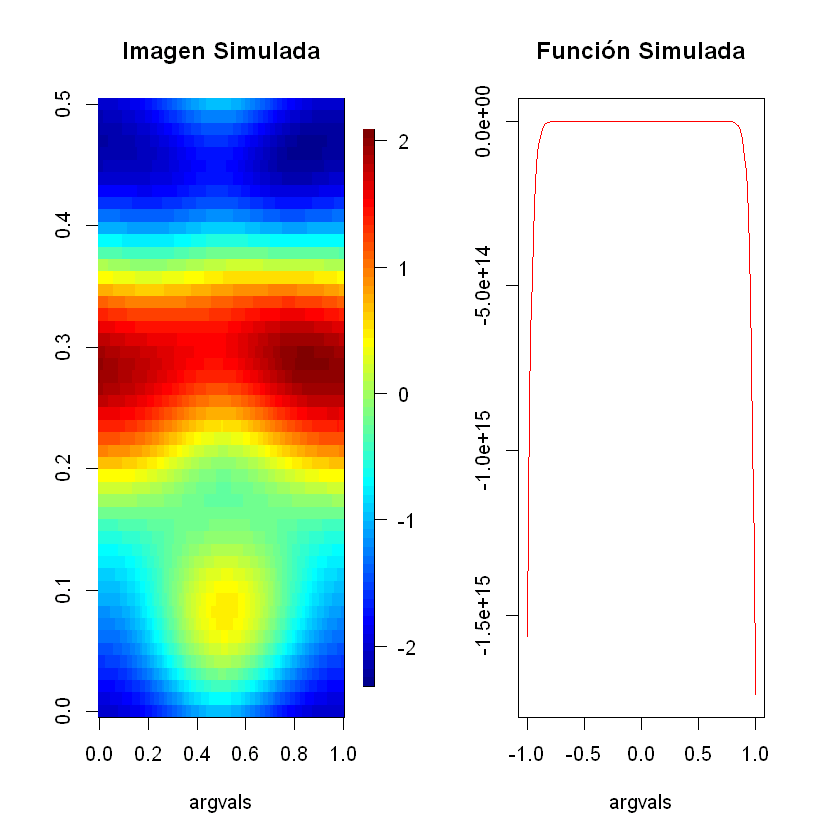

In [5]:
#### Simulación ####
set.seed(123)

N <- 100  # Muestra más grande para alta dimensionalidad
M <- 25
S1_x <- 100
S1_y <- 50
S2 <- 200
T1_x <- seq(0, 1, length.out = S1_x)
T1_y <- seq(0, 0.5, length.out = S1_y)
T2 <- seq(-1, 1, length.out = S2)

sim_data <- simMultiFunData_mod(
  type = "weighted",
  argvals = list(
    list(T1_x, T1_y),
    list(T2)
  ),
  M = list(
    c(5, 5),
    M
  ),
  eFunType = list(
    c("Fourier", "Fourier"),
    "Poly"
  ),
  eValType = "exponential",
  N = N
)

par(mfrow = c(1, 2))
plot(sim_data$simData[[1]], main = "Imagen Simulada", obs = 1)
plot(sim_data$simData[[2]], main = "Función Simulada", obs = 1)
par(mfrow = c(1,1))

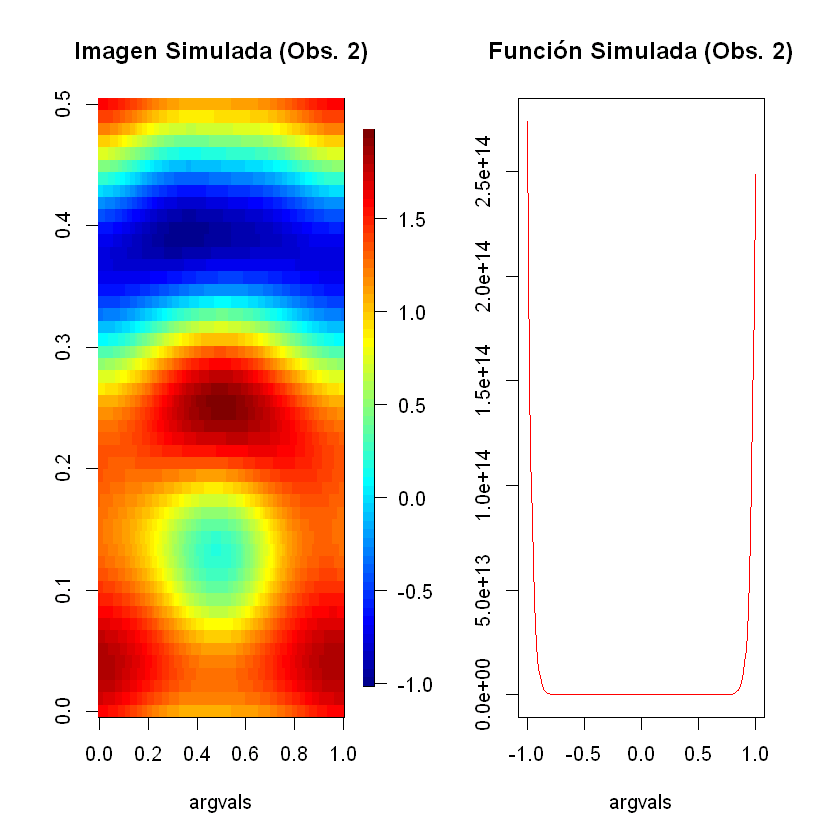

: 

In [ ]:


par(mfrow = c(1, 2))
plot(sim_data$simData[[1]], main = "Imagen Simulada (Obs. 2)", obs = 2) # Muestra la observacion 2
plot(sim_data$simData[[2]], main = "Función Simulada (Obs. 2)", obs = 2) # Muestra la observacion 2
par(mfrow = c(1,1))

### 4.a.2 Usando el artículo de Rousseeuw, P. J., Raymaekers, J., & Hubert, M. (2018), encuentre imágenes outliers y retírelas del dataset.

**The main idea is to split the sample into two half samples, and then to apply a robust scale estimator to each of them.**

---
Se separa el conjunto de datos en dos grupos partiendo en 
$$ h = \frac{n + 1}{2}$$ 

entonces se define en caso **par**,


$$Y_b = \{y_{1}, \dots, y_h\}$$
$$Y_a = \{y_{h+1}, \dots, y_n\}$$

en caso **impar**,


$$Y_b = \{y_{1}, \dots, y_h\}$$
$$Y_a = \{y_{h}, \dots, y_n\}$$

---
Sea la estimación inicial

$$ S_{0, a}(Y) = \frac{med(Z_a)}{\phi^{-1}(0.75)}$$
$$ S_{0, b}(Y) = \frac{med(Z_b)}{\phi^{-1}(0.75)}$$

Donde $Z_a = Y_a - med(Y)$ y $Z_b = med(Y) - Y_b$ y donde $\phi^{-1}(0.75)$ asegura "consistensy" en una gaussiana.

El primer paso de M-estimación son dados por,

$$ S_a (Y) = S_{0, a}(Y) \sqrt{\frac{1}{2\alpha h} \sum_{z_i \in Z_a} \rho_c\left(\frac{z_i}{S_{0, a}(Y)}\right) }$$

$$ S_b (Y) = S_{0, b}(Y) \sqrt{\frac{1}{2\alpha h} \sum_{z_i \in Z_b} \rho_c\left(\frac{z_i}{S_{0, b}(Y)}\right) }$$

Donde, $ h = \left\lfloor\frac{n+1}{2}\right\rfloor$,  $\alpha = \int_0^{\infty} \rho_c(x)d\Phi(x)$.$\rho_c$ La funcion de hubert de escala y $\rho_c(t) = \left(\frac{t}{c}\right)^2\mathbb{1}_{[-c,c]} + \mathbb{1}_{(-\infty,-c]\cup[c,\infty)}$


---
$$
\text{DO}(y; Y) = 
\begin{cases}
\frac{y-\text{med}(Y)}{s_a(Y)} & \text{if } y \geq \text{med}(Y) \\
\frac{\text{med}(Y)-y}{s_b(Y)} & \text{if } y \leq \text{med}(Y)
\end{cases}
$$

Se puede definir *functional directional outlyingness* (fDO) de X, con respecto a una muestra **Y** como,

$$
\text{fDO}(X; Y) = \sum^T_{j=1} DO(X(t_j); Y(t_j)) W(t_j)
$$

Donde $W(.)$ es una función de peso, tal que  $\sum^T_{j=1} W(t_j) = 1$.

Se considera que $DO_i$ tiene una distribución de cola a la derecha, entonces transformando

$$ \{ LDO_1, \dots, LDO_n\} = \{ log(0.1 + DO_1), \dots, log(0.1 + DO_n)\}$$

Se **aproxima** la distribución de $LDO_i$ a una normal, y se obtiene el valor de corte como,

$$\frac{LDO_i - med(LDO)}{MAD(LDO)} < \Phi^{-1}(0.995)$$

---

Se puede encontrar la variabilidad de los valores $DO_i$ como,

$$
vDO(y_i, Y) =\frac{stdev_j(DO(Y_i(t_j); Y(t_j)))}{1 + fDO(Y_i; Y)}
$$

Con lo anterior definido se puede encontrar el **FOM** (*functional outlier map*) como,

$$
(\text{fDO}(Y_i, \mathbf{Y}), \text{vDO}(Y_i, \mathbf{Y}))$$

Se puede definir *combined functional outlyingness* (CFO) de una función $Y_i$ como,

$$
CFO_i  = \sqrt{\left(\frac{\text{fDO}_i}{med(\text{fDO})}\right)^2 + \left(\frac{\text{vDO}_i}{med(\text{vDO})}\right)^2}

**APLICACIÓN A IMAGENES**

$$
\text{fDO}(Y_i; \mathbf{Y}) = \sum^J_{j=1}\sum^K_{k=1} DO(Y_i(j,k); \mathbf{Y}(j,k)) W_{jk}
$$
$$
\text{vDO}(Y_i; \mathbf{Y}) =\frac{stdev_{j,k}(DO(Y_i(j,k); \mathbf{Y}(j,k)))}{1 + fDO(Y_i; \mathbf{Y})}
$$

Y se toma los pesos tal que
$$
W_{j,k} = \frac{1}{(JK)}
$$

En este caso en especial, se toma 10x100x50

$$
\text{fDO}(Y_i; \mathbf{Y}) = \frac{1}{100 \times 50}\sum^{100}_{j=1}\sum^{50}_{k=1} DO(Y_i(j,k); \mathbf{Y}(j,k)) W_{jk}
$$



**Si se puede, no usar supuesto de normalidad.**

In [ ]:


# --- Cargar librerías ---
library(mrfDepth)
library(funData)

dprojdepth <- function(x, z = NULL, options = NULL) {

  ######
  # Check input.
  if (missing(x)) {
    stop("Input argument x is required.")
  }

  #Check the x data.
  x <- data.matrix(x)
  if (!is.numeric(x)) {
    stop("The input argument x must be a numeric data matrix.")
  }
  n1 <- nrow(x)
  p1 <- ncol(x)
  if (n1 > sum(complete.cases(x))) {
    stop("Missing values in x are not allowed.")
  }
  #Check the z data.
  if (is.null(z)) {
    z <- x
  }
  z <- data.matrix(z)
  if (!is.numeric(z)) {
    stop("The input argument z must be a numeric data matrix.")
  }
  n2 <- nrow(z)
  p2 <- ncol(z)
  if (p1 != p2) {
    stop("Data dimension has to be the same for x and z.")
  }
  if (n2 > sum(complete.cases(z))) {
    stop("Missing values in z are not allowed.")
  }
  #check options
  if (is.null(options)) {
    options <- list()
  }
  if (!is.list(options)) {
    stop("options must be a list")
  }

  #####
  #Check data for possible exact fit situations.
  tol <- 1e-7
  scaled.x <- scale(x)
  temp <- attributes(scaled.x)
  column.sd <- temp[["scaled:scale"]]
  if (sum(column.sd <= 1e-14) > 0) {
    warning("One of the variables has zero
            standard deviation. Check the data matrix x.")
    returned.result <- list(depthX = NULL,
                            depthZ = NULL,
                            cutoff = NULL,
                            flagX = NULL,
                            flagY = NULL,
                            singularSubsets  =  NULL,
                            dimension = sum(column.sd > 1e-14),
                            hyperplane = as.numeric(column.sd <= 1e-14),
                            inSubspace = NULL)
    class(returned.result) <- c("mrfDepth", "dprojdepth")
    return(returned.result)
  }
  w1 <- try(svd(scaled.x / sqrt(n1 - 1)), silent = TRUE)
  if (!is.list(w1)) {
    warning("The singular-value decomposition of the data matrix
            x could not be computed.")
    returned.result <- list(depthX = NULL,
                            depthZ = NULL,
                            cutoff = NULL,
                            flagX = NULL,
                            flagY = NULL,
                            singularSubsets  =  NULL,
                            dimension = NULL,
                            hyperplane = NULL,
                            inSubspace = NULL)
    class(returned.result) <- c("mrfDepth", "dprojdepth")
    return(returned.result)
  }
  if (min(w1$d) < tol) {
    warning("An exact fit was found. Check the output for more details.")
    returned.result <- list(depthX = NULL,
                            depthZ = NULL,
                            cutoff = NULL,
                            flagX  = NULL,
                            flagZ = NULL,
                            singularSubsets = NULL,
                            dimension = sum(w1$d > tol),
                            hyperplane = w1$v[which(w1$d == min(w1$d))[1]],
                            inSubspace = NULL)
    class(returned.result) <- c("mrfDepth", "dprojdepth")
    return(returned.result)
  }

  original <- options(warn = 1)
  result <- dirOutl(x = x, z = z, options = options)
  options(warn = original$warn)

  if (!is.null(result$hyperplane)) {
    returned.result <- list(depthX = NULL,
                            depthZ = NULL,
                            cutoff = NULL,
                            flagX = NULL,
                            flagZ = NULL,
                            singularSubsets = NULL,
                            dimension = NULL,
                            hyperplane = result[["hyperplane"]],
                            inSubspace = result[["inSubspace"]])
    class(returned.result) <- c("mrfDepth", "drojdepth")
    return(returned.result)
  } else{
    returned.result <- list(depthX = 1 / (1 + result[["outlyingnessX"]]),
                            depthZ = 1 / (1 + result[["outlyingnessZ"]]),
                            cutoff = 1 / (1 + result[["cutoff"]]),
                            flagX = result[["flagX"]],
                            flagZ = result[["flagZ"]],
                            singularSubsets = result[["singularSubsets"]],
                            dimension = NULL,
                            hyperplane = result[["hyperplane"]],
                            inSubspace = NULL)
    class(returned.result) <- c("mrfDepth", "dprojdepth")
    return(returned.result)
  }
}




# Combinar datos de imagen y función
combined_data <- t(sapply(1:N, function(i) {
  c(as.vector(sim_data$simData[[1]]@X[i,,]), sim_data$simData[[2]]@X[i,])
}))

# Calcular profundidad y manejar posibles errores
depth_result <- tryCatch({
  dprojdepth(combined_data)
}, warning = function(w) {
  message("Advertencia durante el cálculo de profundidad:")
  message(w)
  return(w$result)
}, error = function(e) {
  stop("Error en cálculo de profundidad:", e)
})

# Extraer outliers de forma robusta
if (!is.null(depth_result$flagZ) && is.logical(depth_result$flagZ)) {
  outliers <- which(depth_result$flagZ)
} else if (!is.null(depth_result$flagX) && is.logical(depth_result$flagX)) {
  outliers <- which(depth_result$flagX)
} else {
  outliers <- integer(0)
  message("No se detectaron outliers - estructura de resultado inesperada")
}

# Graficar resultados
if (length(outliers) > 0) {
  layout(matrix(1:(2*length(outliers)), ncol = 2, byrow = TRUE))
  for (i in outliers) {
    plot(sim_data$simData[[1]], main = paste("Imagen Outlier", i), obs = i)
    plot(sim_data$simData[[2]], main = paste("Función Outlier", i), obs = i)
  }
} else {
  print("No se detectaron outliers.")
}

### 4.a.3 Usando el artículo de Allen, G. I. (2013), encuentre las eigenimages y sus respectivos valores propios

Dimensiones del tensor de imágenes: 100 100 50 

k =  1 
Absolute error:

          u:  0.001113411 , v:  2.708969e-05 , w:  0.0002038765 , alphaV:  0.01392519 , alphaW:  0.0005103603 

k =  2 
Absolute error:

          u:  0.000158264 , v:  0.1111416 , w:  0.001134965 , alphaV:  236.7997 , alphaW:  3.720969 

k =  3 
Absolute error:

          u:  0.00113051 , v:  11.52594 , w:  0.3949788 , alphaV:  0.6734813 , alphaW:  10000 


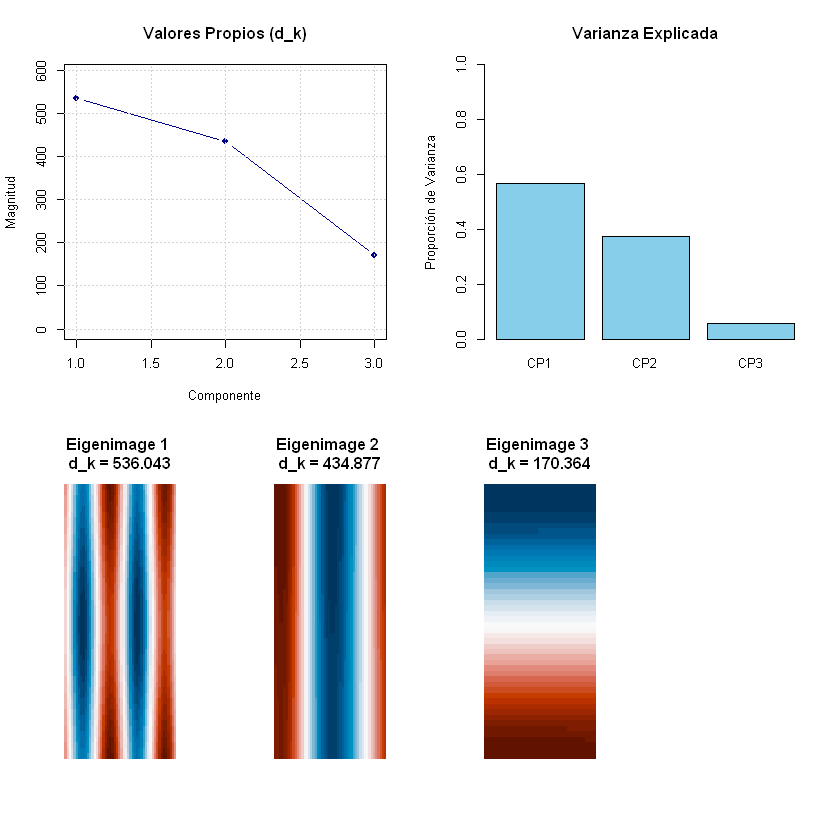

In [ ]:

# ---------------------------
# 1. Preparar datos de imagen
# ---------------------------
# Extraer tensor de imágenes (N x S1_x x S1_y)
image_tensor <- sim_data$simData[[1]]@X
dims <- dim(image_tensor)
cat("Dimensiones del tensor de imágenes:", dims, "\n")

# ---------------------------
# 2. Crear matrices de penalización
# ---------------------------
# Para dirección vertical (S1_x)
Pv <- crossprod(diff(diag(dims[2]))) 

# Para dirección horizontal (S1_y)
Pw <- crossprod(diff(diag(dims[3])))

# ---------------------------
# 3. Ejecutar FCP_TPA
# ---------------------------
set.seed(123)
K <- 3  # Número de componentes principales
fcp_result <- FCP_TPA(
  X = image_tensor,
  K = K,
  penMat = list(v = Pv, w = Pw),
  alphaRange = list(v = c(1e-4, 1e4), w = c(1e-4, 1e4)),
  verbose = TRUE,
  maxIter = 20
)

# ---------------------------
# 4. Visualizar resultados
# ---------------------------
# Configurar área de gráficos
layout(matrix(c(1,1,2,2,3,4,5,6), 2, 4, byrow = TRUE))

# A. Graficar valores propios
plot(fcp_result$d, type = "b", pch = 19, col = "darkblue",
     main = "Valores Propios (d_k)", xlab = "Componente", ylab = "Magnitud",
     ylim = c(0, max(fcp_result$d)*1.1))
grid()

# B. Proporción de varianza explicada
var_exp <- fcp_result$d^2 / sum(fcp_result$d^2)
barplot(var_exp, names.arg = paste0("CP", 1:K),
        main = "Varianza Explicada", col = "skyblue",
        ylab = "Proporción de Varianza", ylim = c(0,1))

# C. Visualizar eigenimages
for(k in 1:K) {
  # Calcular eigenimage como producto exterior
  eigenimage <- fcp_result$V[,k] %o% fcp_result$W[,k]
  
  # Normalizar para visualización
  eigenimage <- eigenimage / max(abs(eigenimage))
  
  # Rotar y espejar para mejor visualización
  image(t(eigenimage)[,ncol(eigenimage):1], 
        col = hcl.colors(50, "RdBu", rev = TRUE),
        main = paste("Eigenimage", k, "\nd_k =", round(fcp_result$d[k],3)),
        axes = FALSE)
}

# D. Comparar con componentes simulados (si se conocen)
# (Asumiendo que tienes acceso a las funciones base verdaderas)
if(exists("trueFuns")) {
  par(mfrow = c(1,2))
  # Visualizar componente verdadera 1
  image(t(trueFuns[[1]]@X[1,,]), main = "Componente Verdadera 1")
  # Visualizar eigenimage 1
  image(t(fcp_result$V[,1] %o% fcp_result$W[,1]), main = "Eigenimage Estimada 1")
}

### 4.a.4. Encuentre las funciones propias y valores propios de las curvas

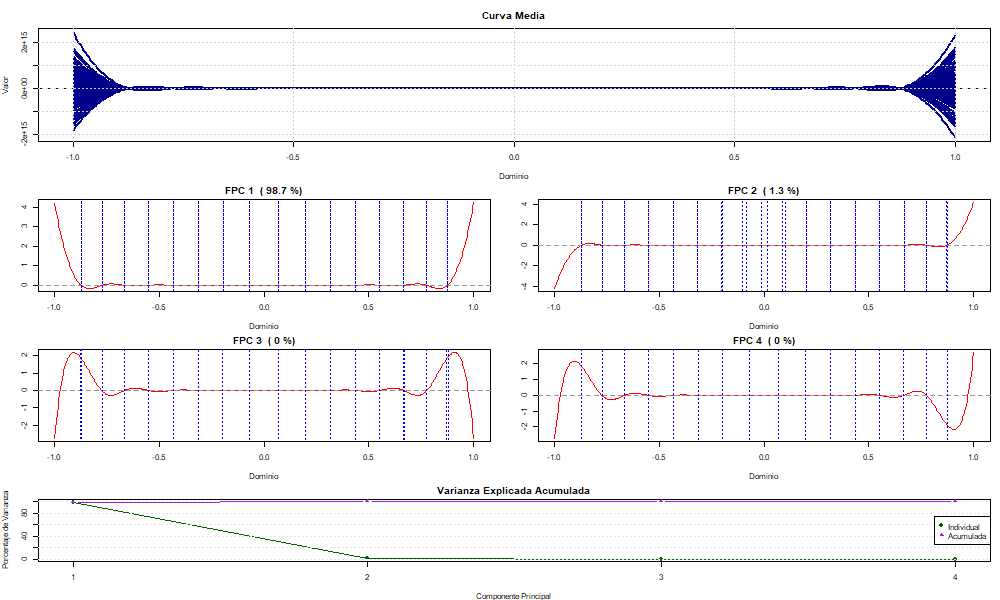

In [ ]:
 -w 1000 -h 600

# -------------------------------------
# Análisis de Componentes Principales Funcionales para las Curvas
# -------------------------------------

# 1. Extraer datos de curvas
curves_data <- sim_data$simData[[2]]@X
argvals_curves <- sim_data$simData[[2]]@argvals[[1]]
N_curves <- nrow(curves_data)
S2 <- ncol(curves_data)

# 2. Crear base funcional (B-spline)
library(fda)
n_basis <- 20  # Número de funciones base
basis_curves <- create.bspline.basis(rangeval = range(argvals_curves), 
                                    nbasis = n_basis)

# 3. Suavizar las curvas en la base
fdPar_curves <- fdPar(fdobj = basis_curves, 
                      Lfdobj = 2,  # Penalizar segunda derivada (suavizado)
                      lambda = 1e-4)  # Parámetro de suavizado

smooth_curves <- smooth.basis(argvals = argvals_curves, 
                              y = t(curves_data), 
                              fdParobj = fdPar_curves)$fd

# 4. FPCA con varimax rotation
nfpca <- 4  # Número de componentes a extraer
fpca_result <- pca.fd(fdobj = smooth_curves, 
                      nharm = nfpca, 
                      centerfns = TRUE)

# Configurar área de gráficos con layout mejorado
layout(matrix(c(1,1,2,3,4,5,6,6), nrow = 4, byrow = TRUE), 
       heights = c(1.2,1,1,0.8))

# A. Media de las curvas (doble altura)
par(mar = c(4,4,3,1))
plot(smooth_curves, main = "Curva Media", 
     col = "darkblue", lty = 1, lwd = 2,
     xlab = "Dominio", ylab = "Valor")
grid()

# B. Componentes principales (4 gráficas)
par(mar = c(4,4,2,1))
for(i in 1:nfpca){
  plot(fpca_result$harmonics[i], 
       main = paste("FPC", i, " (", round(fpca_result$varprop[i]*100,1), "%)"),
       col = "red", lwd = 1.5,
       xlab = "Dominio", ylab = "")
  abline(h = 0, col = "gray60", lty = 2)
  lines(fpca_result$meanfd + 2*sqrt(fpca_result$values[i])*fpca_result$harmonics[i],
        col = "blue", lty = 3)
  lines(fpca_result$meanfd - 2*sqrt(fpca_result$values[i])*fpca_result$harmonics[i],
        col = "blue", lty = 3)
}

# C. Scree plot (doble ancho)
par(mar = c(4,4,2,1))
plot(1:nfpca, fpca_result$varprop[1:nfpca]*100, type = "o",
     main = "Varianza Explicada Acumulada",
     xlab = "Componente Principal", ylab = "Porcentaje de Varianza",
     pch = 19, col = "darkgreen", ylim = c(0,100),
     xaxt = "n")
axis(1, at = 1:nfpca)
abline(h = seq(0,100,by = 20), col = "gray90", lty = 3)
points(1:nfpca, cumsum(fpca_result$varprop[1:nfpca]*100), 
       type = "b", pch = 17, col = "purple")
legend("right", legend = c("Individual", "Acumulada"),
       col = c("darkgreen", "purple"), pch = c(19,17))

### 4.a.5.Usando la metodología propuesta por Happ, C., & Greven, S. (2018, encuentre las funciones propias multidimensionales y sus respectivos valores propios.

In [ ]:

# ----------------------------------------------------------
# Configuración Corregida y Funcional
# ----------------------------------------------------------

library(funData)
library(MFPCA)
library(fields)

# 1. Crear bases 2D correctamente con tensorProduct
# Bases para dirección X (Fourier)
base_x <- eFun_mod(argvals = T1_x, M = 10, type = "Fourier")

# Bases para dirección Y (Fourier)
base_y <- eFun_mod(argvals = T1_y, M = 5, type = "Fourier")

# Crear base 2D mediante producto tensorial
base_2d <- tensorProduct(base_x, base_y)

# 2. Configurar expansiones univariadas corregidas
uni_expansions <- list(
  list( # Para imágenes
    type = "given",
    functions = base_2d,
    scores = matrix(rnorm(100*50, sd = 0.1), nrow = 100) # Scores de ejemplo
  ),
  list( # Para curvas
    type = "splines1Dpen",
    bs = "bs",
    k = 15,
    m = c(2,2)
)

# 3. Ejecutar MFPCA con parámetros verificado
mfpc_result <- MFPCA(
  mFData = multiFunData(
    funData(list(T1_x, T1_y), sim_data$simData[[1]]@X), # Sin transposición
    funData(T2, sim_data$simData[[2]]@X)
  ),
  M = 3,
  uniExpansions = uni_expansions,
  weights = c(1, 0.5),
  fit = FALSE,
  approx.eigen = TRUE,
  verbose = TRUE
)

# 4. Visualización de componentes
layout(matrix(1:3, nrow = 1))
for(m in 1:3){
  image.plot(T1_x, T1_y,
           matrix(mfpc_result$functions[[1]]@X[m,,], 
                  nrow = length(T1_x), ncol = length(T1_y)),
           main = paste("CP", m),
           col = hcl.colors(50, "RdBu", rev = TRUE))
}

ERROR: Error in parse(text = input): <text>:35:1: unexpected symbol
34: # 3. Ejecutar MFPCA con parámetros verificado
35: mfpc_result
    ^
